# DATA PROJECT

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# import dst data loader
import pydst
Dst = pydst.Dst(lang='en') 


pd.set_option('display.max_rows', None)   # show all rows
pd.set_option('display.max_columns', None)   # show all columns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Importing data from Industrial Federation of Robotics:

In [17]:
# Data for industrial robots on industry, year for Denmark
filename = 'ifr_dk.csv'
df_ifr = pd.read_csv(filename, delimiter=';')

# Drop obs that are not relevant (data not valid before 2004)
drop = [str(year) for year in range(1993,2004)]
df_ifr.drop(drop, axis=1, inplace=True)
df_ifr = df_ifr.iloc[1:20, :]

# Renaming columns
col_dict = {}
for i in range(2004, 2016+1): 
    col_dict[str(i)] = f'year{i}' 
    df_ifr[str(i)] = df_ifr[str(i)].apply(str)
col_dict['DK'] = f'BRANCHE_IFR' 

# Omdøber kolonner
df_ifr.rename(columns=col_dict, inplace=True)

# Transponerer med melt
df_ifr_long = pd.melt(df_ifr, id_vars=['BRANCHE_IFR'], var_name='year', value_name='value')
df_ifr_long['year'] = df_ifr_long['year'].str.replace('year', '').astype(int)

df_ifr_long.head(20)


,BRANCHE_IFR,year,value
0,"A-B-Agriculture, forestry, fishing",2004,59
1,C-Mining and quarrying,2004,46
2,10-12-Food and beverages,2004,145
3,13-15-Textiles,2004,95
4,16-Wood and furniture,2004,262
5,17-18-Paper,2004,14
6,19-22-Plastic and chemical products,2004,295
7,"23-Glass, ceramics, stone, mineral products (n...",2004,0
8,24-Basic metals,2004,70
9,25-Metal products (non-automotive),2004,928


Importing data from Danmarks Statistik:

In [7]:
# Inspicerer indhold
nabb69_vars = Dst.get_variables(table_id='NABB69')
nabb69_vars.id.unique()

# Importing data from statistikbanken through an API
variables = {'SOCIO':['EMPM_DC'],'BRANCHE':['*'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer data
nabb69 = Dst.get_data(table_id = 'NABB69', variables=variables)
nabb69.sort_values(by=['SOCIO', 'TID', 'BRANCHE'], inplace=True)

# Ordner industri-koder: Klar til merge med ifr
# Dictionary for oversættelse af industri-koder
industry = nabb69.BRANCHE
dict_nabb69    = {x[:5]: x[6:] for x in industry}
dict_crosswalk = {'01000':'A-B-Agriculture, forestry, fishing',
                  '02000':'A-B-Agriculture, forestry, fishing',
                  '03000':'A-B-Agriculture, forestry, fishing',
                  '06090':'C-Mining and quarrying',
                  '10120': '10-12-Food and beverages',
                  '13150':'13-15-Textiles',
                  '16000': '16-Wood and furniture',
                  '17000':'17-18-Paper',
                  '18000':'17-18-Paper',
                  '19000':'19-22-Plastic and chemical products',
                  '20000':'19-22-Plastic and chemical products',
                  '21000':'19-22-Plastic and chemical products',
                  '22000':'19-22-Plastic and chemical products',
                  '23000':'23-Glass, ceramics, stone, mineral products (n...',
                  '24000':'24-Basic metals',
                  '25000':'25-Metal products (non-automotive)',
                  '28000':'28-Industrial machinery',
                  '26000':'26-27-Electrical/electronics',
                  '27000':'26-27-Electrical/electronics',
                  '29000':'29-Automotive',
                  '30000':'30-Other vehicles',
                  '31320':'91-All other manufacturing branches',
                  '33000':'91-All other manufacturing branches',
                  '35000':'E-Electricity, gas, water supply',
                  '36000':'E-Electricity, gas, water supply',
                  '37390':'E-Electricity, gas, water supply',
                  '41430':'Construction',
                  '72002':'P-Education/research/development',
                  '85202':'P-Education/research/development'}

# Opdaterer dictionary så alle andre kategorier får '90'.
dict_crosswalk.update({
    str(key): '90-All other non-manufacturing branches'
    for key in range(0, 100000)
    if str(key) not in dict_crosswalk
})

# Tilføjer ny variabel med talkoder for branche og bruger dictionary til at oversætte industrikoder
nabb69['BRANCHE_K']   = nabb69['BRANCHE'].str[:5]
nabb69['BRANCHE_IFR'] = nabb69['BRANCHE_K'].map(dict_crosswalk)

# Aggregerer på IFR-industrier og tid
nabb69['emp_ifr'] = nabb69.groupby(['BRANCHE_IFR', 'TID'])['INDHOLD'].transform(sum)

nabb69 = nabb69[nabb69['BRANCHE_K'].str.isnumeric()]

# Beholder kun subset: relevante obs og variable
nabb69 = nabb69.loc[:, ['TID', 'BRANCHE_IFR', 'emp_ifr']]
nabb69 = nabb69.drop_duplicates(subset=['BRANCHE_IFR', 'TID'])
nabb69.rename(columns={'TID': 'year'}, inplace=True)

nabb69.head(10)


,SOCIO,BRANCHE,TID,INDHOLD,BRANCHE_K,BRANCHE_IFR
783,Employment (number),01000 Agriculture and horticulture,2004,71446,01000,"A-B-Agriculture, forestry, fishing"
784,Employment (number),02000 Forestry,2004,4386,02000,"A-B-Agriculture, forestry, fishing"
785,Employment (number),03000 Fishing,2004,4025,03000,"A-B-Agriculture, forestry, fishing"
786,Employment (number),06090 Mining and quarrying,2004,3492,06090,C-Mining and quarrying
787,Employment (number),"10120 Manufacture of food products, beverages ...",2004,69960,10120,10-12-Food and beverages
788,Employment (number),13150 Textiles and leather products,2004,9995,13150,13-15-Textiles
789,Employment (number),16000 Manufacture of wood and wood products,2004,12614,16000,16-Wood and furniture
790,Employment (number),17000 Manufacture of paper and paper products,2004,7587,17000,17-18-Paper
791,Employment (number),18000 Printing etc.,2004,12611,18000,17-18-Paper
792,Employment (number),19000 Oil refinery etc.,2004,806,19000,19-22-Plastic and chemical products


# Analysis

First part: Descriptive statistics

Gør data klar til plot

In [4]:
# Merger datasæt på IFR og year
ifr_nabb69 = pd.merge(df_ifr_long, nabb69, on=['BRANCHE_IFR', 'year'], how='left')
ifr_nabb69.value = ifr_nabb69.value.astype(float)

# Laver dictionary med pænerer værdier på IFR-navne til legends
dict_legend = {
    'A-B-Agriculture, forestry, fishing': 'Agriculture, forestry, fishing',
    'C-Mining and quarrying': 'Mining and quarrying',
    '10-12-Food and beverages': 'Food and beverages',
    '13-15-Textiles': 'Textiles',
    '16-Wood and furniture': 'Wood and furniture',
    '17-18-Paper': 'Paper',
    '19-22-Plastic and chemical products': 'Plastic and chemical products',
    '23-Glass, ceramics, stone, mineral products (n...': 'Glass, ceramics, stone, mineral products',
    '24-Basic metals': 'Basic metals',
    '25-Metal products (non-automotive)': 'Metal products (non-automotive)',
    '26-27-Electrical/electronics': 'Electrical/electronics',
    '28-Industrial machinery': 'Industrial machinery',
    '29-Automotive': 'Automotive',
    '30-Other vehicles': 'Other vehicles',
    '91-All other manufacturing branches': 'All other manufacturing branches',
    'E-Electricity, gas, water supply': 'Electricity, gas, water supply',
    'Construction': 'Construction',
    'P-Education/research/development': 'Education/research/development'
}
ifr_nabb69['ifr_legend'] = ifr_nabb69['BRANCHE_IFR'].map(dict_legend)

# Udregner robost pr. ths. worker (relativt mål for robot-intensiteten i en industri)
ifr_nabb69['rob_pr_ths'] = ifr_nabb69.value/ifr_nabb69.emp_ifr
ifr_nabb69 = ifr_nabb69.dropna()

# Udregner mean pr. år på tværs af industrier
rob_pr_ths_mean      = ifr_nabb69.groupby(['year'])['rob_pr_ths'].mean()
ifr_nabb69           = pd.merge(ifr_nabb69, rob_pr_ths_mean, on=['year'], how='left')

# Renamer kolonner
ifr_nabb69.rename(columns={'rob_pr_ths_x': 'rob_pr_ths',
                           'rob_pr_ths_y': 'rob_pr_ths_y_mean'}, inplace=True)

ifr_nabb69.head(10)

,BRANCHE_IFR,year,value,emp_ifr,ifr_legend,rob_pr_ths,rob_pr_ths_y_mean
0,"A-B-Agriculture, forestry, fishing",2004,59.0,79857.0,"Agriculture, forestry, fishing",0.000739,0.006274
1,C-Mining and quarrying,2004,46.0,3492.0,Mining and quarrying,0.013173,0.006274
2,10-12-Food and beverages,2004,145.0,69960.0,Food and beverages,0.002073,0.006274
3,13-15-Textiles,2004,95.0,9995.0,Textiles,0.009505,0.006274
4,16-Wood and furniture,2004,262.0,12614.0,Wood and furniture,0.020771,0.006274
5,17-18-Paper,2004,14.0,20198.0,Paper,0.000693,0.006274
6,19-22-Plastic and chemical products,2004,295.0,46831.0,Plastic and chemical products,0.006299,0.006274
7,24-Basic metals,2004,70.0,5520.0,Basic metals,0.012681,0.006274
8,25-Metal products (non-automotive),2004,928.0,38487.0,Metal products (non-automotive),0.024112,0.006274
9,28-Industrial machinery,2004,7.0,63927.0,Industrial machinery,0.000109,0.006274


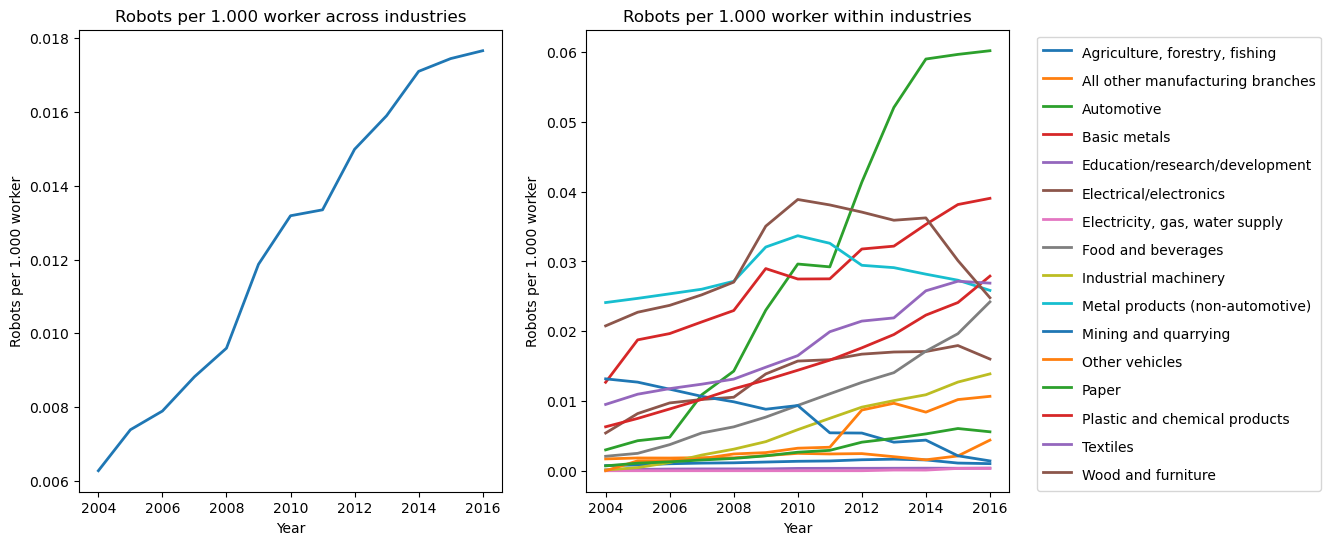

In [5]:
# Plotter
def plot_rob_pr_ths():
    plot = plt.figure(figsize=(12,6))

    # a. create line plot for aggregate development in robots across industries
    ax = plot.add_subplot(1,2,1)

    ax.plot(ifr_nabb69.year, ifr_nabb69.rob_pr_ths_y_mean, label=None, marker=None, linestyle='-', linewidth=2)
    #x_pos = ifr_nabb69.year.iloc[-1] + 0.2
    #y_pos = ifr_nabb69.rob_pr_ths_y_mean.iloc[-1]
    
    ax.set_title(f'Robots per 1.000 worker across industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')

    # b. plot for each industry
    ax = plot.add_subplot(1,2,2)

    for industry, data in ifr_nabb69.groupby('ifr_legend'):
        #ax.plot(data.year, data.rob_pr_ths, label=None, marker=None, linestyle='-', linewidth=2)
        ax.plot(data.year, data.rob_pr_ths, label=industry, marker=None, linestyle='-', linewidth=2)
        #x_pos = data.year.iloc[-1] + 0.2
        #y_pos = data.rob_pr_ths.iloc[-1]
        #ax.annotate(industry, xy=(x_pos, y_pos), ha='left', va='center')

    ax.set_title(f'Robots per 1.000 worker within industries')
    ax.set_xlabel(f'Year')
    ax.set_ylabel(f'Robots per 1.000 worker')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), handleheight=1.97)

plot_rob_pr_ths()  

In [37]:
# Importing NP25
np25_vars = Dst.get_variables(table_id='NP25')
np25_vars.id.unique()

#Importing data from statistikbanken through an API
variables = {'BRANCHE':['*'],'TYPE':['LP', 'IT', 'AK', 'LQ', 'TF'],'PRISENHED':['VPR_V'],'Tid':['2004','2005','2006','2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', '2015','2016']}

# Importerer udvalgt subset af data
np25 = Dst.get_data(table_id = 'NP25', variables=variables)
np25.sort_values(by=['TYPE', 'TID', 'BRANCHE'], inplace=True)

# Subsetter branche-variabel og gør klar til at fjerne aggregerede industrier
# Dictionary for oversættelse af industri-koder
industry = np25.BRANCHE
dict_np25    = {x[:5]: x[6:] for x in industry}

# ...Også dem med en nøgle der starter med bogstaver
# create a copy of the dictionary
raw_dict_np25 = dict_np25
dict_np25 = dict_np25.copy()

# loop through the keys of the dictionary
for key in raw_dict_np25.keys():
    # check if the key is a digit or not
    if not key.isdigit():
        # remove the key-value pair from the copy of the dictionary
        del dict_np25[key]

# update the original dictionary with the modified copy
dict_np25 = dict_np25.copy()

# Now remove all observations in np25, that are not included in dict_np25
np25.BRANCHE[:5].head(10)
np25['BRANCHE_K'] = np25.BRANCHE[:5].map(dict_np25)


#np25 = pd.merge(np25, pd.DataFrame({'key': list(dict_np25.keys()), 'value_dict': list(dict_np25.values())}), on='key', how='left')

# keep only the rows where the value_dict column is not null (i.e. where there was a match in the dictionary)
#np25 = np25.loc[np25['value_dict'].notnull()].drop(columns=['value_dict'])
#np25.head(10)

#dict_np25

1429                   01000 Agriculture and horticulture
1480                                       02000 Forestry
1533                                        03000 Fishing
1240                           06090 Mining and quarrying
1312    10120 Manufacture of food products, beverages ...
Name: BRANCHE, dtype: object

In [6]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

Second part: Correlation and regression analysis

# Conclusion

ADD CONCISE CONLUSION.